In [1]:
#https://radimrehurek.com/gensim/models/word2vec.html
#http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/

In [1]:
import gensim 
import pandas as pd
import logging
import math
import numpy as np


C:\Users\Simo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
songs = pd.read_csv('spotify_dataset.csv', header=None, skiprows=[0], usecols=[0,1,2,3]).dropna()

In [3]:
songs.columns = ['user_id', 'artistname','trackname','playlistname']
songs.head()

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010


In [4]:
songs.shape

(12867139, 4)

In [4]:
songs["combined"] = songs["artistname"] + " - " +songs["trackname"]

In [6]:
songs.head()

,user_id,artistname,trackname,playlistname,combined
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010,Elvis Costello - (The Angels Wanna Wear My) Re...
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010,Elvis Costello & The Attractions - (What's So ...
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010,Tiffany Page - 7 Years Too Late
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010,Elvis Costello & The Attractions - Accidents W...
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010,Elvis Costello - Alison


In [71]:
songs[songs['playlistname'] == 'Serious About Song Effects'].head()

,user_id,artistname,trackname,playlistname,combined


In [131]:
songs.iloc[2311400]

user_id                         00123e0f544dee3ab006aa7f1e5725a7
artistname                                          Robin Trower
trackname                      Sail On - 2012 Remastered Version
playlistname                                 Trower, Procol, Noy
combined        Robin Trower - Sail On - 2012 Remastered Version
Name: 2316740, dtype: object

In [5]:
songs.shape

(12901979, 4)

In [5]:
#https://stackoverflow.com/questions/43899471/remove-groups-with-size-smaller-than-mean-group-size-in-pandas
playlists = songs.groupby(['playlistname']).filter(lambda x: len(x) > 9)

In [6]:
#https://stackoverflow.com/questions/22219004/grouping-rows-in-list-in-pandas-groupby
playlists = playlists.groupby(['playlistname']).agg({'combined':lambda x: list(x)}) 

In [7]:
playlists.head()

,combined
playlistname,
,"[Strange Talk - So So LaLa, The American Breed..."
waves,"[The Wave Pictures - All My Friends, The Wave ..."
11,"[Valencia - 3000 Miles, Childish Gambino - 300..."
Frida,"[Elliot Goldenthal - Alcoba Azul, Elliot Golde..."
New tunes 05/11,[Tarantino Rodrigues - After Dark (Dusk Til Da...


In [9]:
playlists.shape

(129573, 1)

In [10]:
def preprocess(playlist):
    songs = []
    for song in playlist:
        #Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
        #TODO: remove nan:s before checking if playlist >= 10
        #if isinstance(song, float) == False:
            #TODO: is preprocessing needed, to lowercase
            #preprocessed_song = gensim.utils.simple_preprocess(song)
        songs.append(song)
            
    return songs


def to_document(playlists):
    documents = []
    for index, row in playlists.iterrows():
        preprocessed_songs = preprocess(row['combined'])
        documents.append(preprocessed_songs)

    return documents    

In [11]:
#no_empty_playlists = playlists.dropna(subset=['trackname'])
documents = to_document(playlists)

In [12]:
len(documents)

129573

In [15]:
documents[0]

['Strange Talk - So So LaLa',
 'The American Breed - Bend Me, Shape Me',
 'Soundgarden - Burden In My Hand',
 'Soloman Burke - Cry To Me',
 'Aerosmith - Dream On',
 "Urge Overkill - Girl, You'll Be A Woman Soon",
 'Al Green - Here I Am Baby',
 "Kay's Choice - I'm Not an Addict",
 'Something Corporate - Konstantine',
 'The Verve - Lucky Man',
 'Aaliyah - More Than a Lover',
 'Alien Ant Farm - Movies',
 'Radiohead - My Iron Lung',
 'Alanis Morissette - Not The Doctor',
 'Curtis Mayfield - Pusherman',
 '311 - Sometimes Jacks Rule the Realm',
 'Damien Rice - The Blowers Daughter',
 'Fastball - The Way',
 'Silverchair - Tomorrow',
 'Van Morrison - Wild Nights',
 "Barry White - You're The First, The Last, My",
 'Mos Def - Auditorium',
 'Wu-Tang Clan - C.R.E.A.M.',
 'Buena Vista Social Club - Chan Chan',
 'Wu-Tang Clan - Gravel Pit',
 'Max Herre - King von Prenzlauer Berg',
 "LCD Soundsystem - New York, I Love You But You're Bringing Me Down",
 'Razorlight - North London Trash',
 'De La Soul 

In [13]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [76]:


index = np.random.choice(range(len(documents)), 20000, replace=False)

In [77]:
test = np.array(documents)[index[:10000]].tolist()
validation = np.array(documents)[index[10000:]].tolist()

In [75]:
#test[0]

In [ ]:
#https://github.com/manasRK/word2vec-recommender/blob/master/semsim_train.py
#https://arxiv.org/abs/1804.04212
#http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
#https://stackoverflow.com/questions/38287772/cbow-v-s-skip-gram-why-invert-context-and-target-words

In [78]:
#sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram
#min_count (int, optional) – Ignores all words with total frequency lower than this.
#window (int, optional) – Maximum distance between the current and predicted word within a sentence.
#sample (float, optional) – The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).

#hs ({0, 1}, optional) – If 1, hierarchical softmax will be used for model training.
#If 0, and negative is non-zero, negative sampling will be used.

#negative (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many 
#“noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.

#model = gensim.models.Word2Vec(documents, min_count=1, workers=16, sg=1, size = 300, hs=1, window = 5)
#model.train(documents,total_examples=len(documents),epochs=1)

#window_size window-size
#it number of epochs 
#sample sub-sampling parameter
#power-alpha negative sampling distribution parameter

window_size=7
it=90 #increasing this leads to returning words with wrong similarity
sample=0.0001 
power_alpha=-0.5

#other
size_embedding=50
neg_sample=5
workers=10
min_count=0 #cold start?


model = gensim.models.Word2Vec(test, size=size_embedding, window=window_size,
                 min_count=min_count, workers=workers, sg=1, iter=it,
                 sample=sample, negative=neg_sample, alpha=power_alpha)

model.train(test,total_examples=len(test), epochs=model.iter)

2019-02-08 09:27:11,984 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-02-08 09:27:11,985 : INFO : collecting all words and their counts
2019-02-08 09:27:11,985 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-02-08 09:27:12,414 : INFO : collected 484843 word types from a corpus of 895853 raw words and 10000 sentences
2019-02-08 09:27:12,416 : INFO : Loading a fresh vocabulary
2019-02-08 09:27:14,880 : INFO : min_count=0 retains 484843 unique words (100% of original 484843, drops 0)
2019-02-08 09:27:14,882 : INFO : min_count=0 leaves 895853 word corpus (100% of original 895853, drops 0)
2019-02-08 09:27:16,636 : INFO : deleting the raw counts dictionary of 484843 items
2019-02-08 09:27:16,656 : INFO : sample=0.0001 downsamples 0 most-common words
2019-02-08 09:27:16,658 : INFO : downsampling leaves estimated 895853 word corpus (100.0% of prior 895853)
2019-02-08 09:27:18,015 : INFO : estimated required memory for 4

2019-02-08 09:27:36,640 : INFO : EPOCH 6 - PROGRESS: at 98.19% examples, 410969 words/s, in_qsize 3, out_qsize 1
2019-02-08 09:27:36,641 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:27:36,683 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:27:36,687 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:27:36,695 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:27:36,696 : INFO : EPOCH - 6 : training on 895853 raw words (871124 effective words) took 2.1s, 413998 effective words/s
2019-02-08 09:27:37,704 : INFO : EPOCH 7 - PROGRESS: at 46.07% examples, 382723 words/s, in_qsize 19, out_qsize 0
2019-02-08 09:27:38,651 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:27:38,676 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:27:38,678 : INFO : worker thread finished; awaiting finish of 7 more threads
2

2019-02-08 09:27:50,445 : INFO : EPOCH 13 - PROGRESS: at 44.39% examples, 369545 words/s, in_qsize 19, out_qsize 0
2019-02-08 09:27:51,368 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:27:51,371 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:27:51,423 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:27:51,428 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:27:51,475 : INFO : EPOCH 13 - PROGRESS: at 96.43% examples, 405000 words/s, in_qsize 5, out_qsize 1
2019-02-08 09:27:51,476 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:27:51,481 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:27:51,519 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:27:51,521 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:27:51,536 : INFO : worker thr

2019-02-08 09:28:04,387 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:28:04,405 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:28:04,420 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:28:04,449 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:28:04,456 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:28:04,463 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:28:04,464 : INFO : EPOCH - 19 : training on 895853 raw words (871124 effective words) took 2.1s, 410329 effective words/s
2019-02-08 09:28:05,493 : INFO : EPOCH 20 - PROGRESS: at 47.14% examples, 384025 words/s, in_qsize 19, out_qsize 0
2019-02-08 09:28:06,372 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:28:06,375 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:28:06,3

2019-02-08 09:28:16,834 : INFO : EPOCH - 25 : training on 895853 raw words (871124 effective words) took 2.0s, 427903 effective words/s
2019-02-08 09:28:17,855 : INFO : EPOCH 26 - PROGRESS: at 48.43% examples, 396392 words/s, in_qsize 19, out_qsize 0
2019-02-08 09:28:18,758 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:28:18,766 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:28:18,777 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:28:18,786 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:28:18,812 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:28:18,840 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:28:18,851 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:28:18,872 : INFO : EPOCH 26 - PROGRESS: at 98.20% examples, 419251 words/s, in_qsize 2, out_qsize 

2019-02-08 09:28:31,159 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:28:31,161 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:28:31,183 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:28:31,204 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:28:31,209 : INFO : EPOCH 32 - PROGRESS: at 100.00% examples, 424646 words/s, in_qsize 0, out_qsize 1
2019-02-08 09:28:31,210 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:28:31,210 : INFO : EPOCH - 32 : training on 895853 raw words (871124 effective words) took 2.1s, 424395 effective words/s
2019-02-08 09:28:32,236 : INFO : EPOCH 33 - PROGRESS: at 48.43% examples, 394952 words/s, in_qsize 20, out_qsize 0
2019-02-08 09:28:33,122 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:28:33,149 : INFO : worker thread finished; awaiting finish of 8 more threa

2019-02-08 09:28:43,988 : INFO : EPOCH - 38 : training on 895853 raw words (871124 effective words) took 2.2s, 397637 effective words/s
2019-02-08 09:28:45,004 : INFO : EPOCH 39 - PROGRESS: at 46.07% examples, 379222 words/s, in_qsize 20, out_qsize 0
2019-02-08 09:28:46,010 : INFO : EPOCH 39 - PROGRESS: at 90.42% examples, 390513 words/s, in_qsize 10, out_qsize 0
2019-02-08 09:28:46,012 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:28:46,015 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:28:46,052 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:28:46,056 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:28:46,111 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:28:46,124 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:28:46,137 : INFO : worker thread finished; awaiting finish of 3 more threa

2019-02-08 09:28:58,950 : INFO : EPOCH 45 - PROGRESS: at 96.43% examples, 406141 words/s, in_qsize 5, out_qsize 1
2019-02-08 09:28:58,951 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:28:58,972 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:28:58,978 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:28:59,004 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:28:59,014 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:28:59,026 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:28:59,027 : INFO : EPOCH - 45 : training on 895853 raw words (871124 effective words) took 2.1s, 412722 effective words/s
2019-02-08 09:29:00,052 : INFO : EPOCH 46 - PROGRESS: at 47.14% examples, 385467 words/s, in_qsize 19, out_qsize 0
2019-02-08 09:29:00,984 : INFO : worker thread finished; awaiting finish of 9 more thread

2019-02-08 09:29:11,888 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:29:11,889 : INFO : EPOCH - 51 : training on 895853 raw words (871124 effective words) took 2.1s, 406643 effective words/s
2019-02-08 09:29:12,915 : INFO : EPOCH 52 - PROGRESS: at 47.14% examples, 385339 words/s, in_qsize 20, out_qsize 0
2019-02-08 09:29:13,866 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:29:13,881 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:29:13,896 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:29:13,914 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:29:13,933 : INFO : EPOCH 52 - PROGRESS: at 96.43% examples, 405327 words/s, in_qsize 5, out_qsize 1
2019-02-08 09:29:13,933 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:29:13,950 : INFO : worker thread finished; awaiting finish of 4 more thread

2019-02-08 09:29:26,797 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:29:26,862 : INFO : EPOCH 58 - PROGRESS: at 96.43% examples, 397143 words/s, in_qsize 5, out_qsize 1
2019-02-08 09:29:26,864 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:29:26,868 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:29:26,888 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:29:26,902 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:29:26,910 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:29:26,918 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:29:26,919 : INFO : EPOCH - 58 : training on 895853 raw words (871124 effective words) took 2.1s, 407797 effective words/s
2019-02-08 09:29:27,952 : INFO : EPOCH 59 - PROGRESS: at 46.07% examples, 373137 words/s, in_qsize 20, out_qsize 

2019-02-08 09:29:39,708 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:29:39,714 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:29:39,715 : INFO : EPOCH - 64 : training on 895853 raw words (871124 effective words) took 2.1s, 416366 effective words/s
2019-02-08 09:29:40,726 : INFO : EPOCH 65 - PROGRESS: at 44.82% examples, 371193 words/s, in_qsize 19, out_qsize 0
2019-02-08 09:29:41,689 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:29:41,706 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:29:41,732 : INFO : EPOCH 65 - PROGRESS: at 93.48% examples, 400687 words/s, in_qsize 7, out_qsize 1
2019-02-08 09:29:41,733 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:29:41,736 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:29:41,801 : INFO : worker thread finished; awaiting finish of 5 more thread

2019-02-08 09:29:54,770 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:29:54,787 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:29:54,815 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:29:54,857 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:29:54,883 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:29:54,892 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:29:54,918 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:29:54,923 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:29:54,930 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:29:54,931 : INFO : EPOCH - 71 : training on 895853 raw words (871124 effective words) took 2.2s, 397565 effective words/s
2019-02-08 09:29:55,972 : INFO : EPOCH 72 - P

2019-02-08 09:30:07,515 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:30:07,522 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:30:07,531 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:30:07,532 : INFO : EPOCH - 77 : training on 895853 raw words (871124 effective words) took 2.1s, 411356 effective words/s
2019-02-08 09:30:08,568 : INFO : EPOCH 78 - PROGRESS: at 47.14% examples, 381444 words/s, in_qsize 19, out_qsize 0
2019-02-08 09:30:09,468 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:30:09,494 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:30:09,504 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:30:09,506 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:30:09,553 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:30:09,5

2019-02-08 09:30:22,631 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:30:22,645 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:30:22,663 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:30:22,673 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:30:22,731 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:30:22,748 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:30:22,773 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:30:22,793 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:30:22,799 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:30:22,805 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:30:22,806 : INFO : EPOCH - 84 : training on 895853 raw words (871124 effecti

2019-02-08 09:30:36,028 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:30:36,049 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:30:36,053 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:30:36,065 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:30:36,066 : INFO : EPOCH - 90 : training on 895853 raw words (871124 effective words) took 2.3s, 385567 effective words/s
2019-02-08 09:30:36,067 : INFO : training on a 80626770 raw words (78401160 effective words) took 192.3s, 407600 effective words/s
C:\Users\Simo\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
2019-02-08 09:30:36,186 : INFO : training model with 10 workers on 484843 vocabulary and 50 features, using sg=1 hs=0 sample=0.0001 negative=5 window=7
2019-02-08 09:30:37,232 : INFO : EPOCH 1

2019-02-08 09:30:49,130 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:30:49,137 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:30:49,137 : INFO : EPOCH - 6 : training on 895853 raw words (871124 effective words) took 2.1s, 407157 effective words/s
2019-02-08 09:30:50,145 : INFO : EPOCH 7 - PROGRESS: at 41.88% examples, 352803 words/s, in_qsize 18, out_qsize 1
2019-02-08 09:30:51,149 : INFO : EPOCH 7 - PROGRESS: at 90.42% examples, 392411 words/s, in_qsize 10, out_qsize 0
2019-02-08 09:30:51,162 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:30:51,163 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:30:51,200 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:30:51,203 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:30:51,267 : INFO : worker thread finished; awaiting finish of 5 more threads


2019-02-08 09:31:04,030 : INFO : EPOCH 13 - PROGRESS: at 93.48% examples, 399535 words/s, in_qsize 7, out_qsize 1
2019-02-08 09:31:04,031 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:31:04,046 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:31:04,096 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:31:04,103 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:31:04,128 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:31:04,138 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:31:04,143 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:31:04,153 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:31:04,153 : INFO : EPOCH - 13 : training on 895853 raw words (871124 effective words) took 2.1s, 406985 effective words/s
2019-02-08 09:31:05,16

2019-02-08 09:31:16,939 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:31:16,947 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:31:16,966 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:31:16,967 : INFO : EPOCH - 19 : training on 895853 raw words (871124 effective words) took 2.1s, 406165 effective words/s
2019-02-08 09:31:17,986 : INFO : EPOCH 20 - PROGRESS: at 43.60% examples, 361975 words/s, in_qsize 20, out_qsize 0
2019-02-08 09:31:18,937 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:31:18,939 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:31:18,940 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:31:18,980 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:31:19,004 : INFO : EPOCH 20 - PROGRESS: at 96.43% examples, 408632 words/s, in_qsize 5, out_qsize 

2019-02-08 09:31:31,825 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:31:31,830 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:31:31,847 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:31:31,887 : INFO : EPOCH 26 - PROGRESS: at 95.89% examples, 402817 words/s, in_qsize 5, out_qsize 1
2019-02-08 09:31:31,887 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:31:31,888 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:31:31,913 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:31:31,946 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:31:31,949 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:31:31,962 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:31:31,964 : INFO : EPOCH - 26 : training on 895853 ra

2019-02-08 09:31:44,975 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:31:44,996 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:31:45,000 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:31:45,013 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:31:45,014 : INFO : EPOCH - 32 : training on 895853 raw words (871124 effective words) took 2.2s, 399238 effective words/s
2019-02-08 09:31:46,035 : INFO : EPOCH 33 - PROGRESS: at 46.07% examples, 377588 words/s, in_qsize 20, out_qsize 0
2019-02-08 09:31:46,991 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:31:47,011 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:31:47,013 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:31:47,015 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:31:47,0

2019-02-08 09:31:59,927 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:31:59,941 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:31:59,942 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:31:59,955 : INFO : EPOCH 39 - PROGRESS: at 94.99% examples, 406000 words/s, in_qsize 6, out_qsize 1
2019-02-08 09:31:59,956 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:31:59,964 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:32:00,037 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:32:00,044 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:32:00,050 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:32:00,067 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:32:00,069 : INFO : worker thread finished; awaiting f

2019-02-08 09:32:12,737 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:32:12,738 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:32:12,790 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:32:12,794 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:32:12,802 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:32:12,803 : INFO : EPOCH - 45 : training on 895853 raw words (871124 effective words) took 2.1s, 409740 effective words/s
2019-02-08 09:32:13,818 : INFO : EPOCH 46 - PROGRESS: at 46.11% examples, 379053 words/s, in_qsize 20, out_qsize 1
2019-02-08 09:32:14,745 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:32:14,773 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:32:14,775 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:32:14,7

2019-02-08 09:32:26,598 : INFO : EPOCH 52 - PROGRESS: at 44.82% examples, 368541 words/s, in_qsize 20, out_qsize 0
2019-02-08 09:32:27,556 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:32:27,568 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:32:27,575 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:32:27,578 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:32:27,620 : INFO : EPOCH 52 - PROGRESS: at 96.43% examples, 405904 words/s, in_qsize 5, out_qsize 1
2019-02-08 09:32:27,621 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:32:27,638 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:32:27,659 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:32:27,667 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:32:27,676 : INFO : worker thr

2019-02-08 09:32:40,472 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:32:40,475 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:32:40,495 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:32:40,518 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:32:40,519 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:32:40,532 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:32:40,533 : INFO : EPOCH - 58 : training on 895853 raw words (871124 effective words) took 2.1s, 411659 effective words/s
2019-02-08 09:32:41,588 : INFO : EPOCH 59 - PROGRESS: at 48.43% examples, 383699 words/s, in_qsize 19, out_qsize 0
2019-02-08 09:32:42,464 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:32:42,485 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:32:42,4

2019-02-08 09:32:53,436 : INFO : EPOCH - 64 : training on 895853 raw words (871124 effective words) took 2.2s, 403299 effective words/s
2019-02-08 09:32:54,453 : INFO : EPOCH 65 - PROGRESS: at 43.32% examples, 359686 words/s, in_qsize 19, out_qsize 0
2019-02-08 09:32:55,432 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:32:55,445 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:32:55,446 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:32:55,449 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:32:55,502 : INFO : EPOCH 65 - PROGRESS: at 96.43% examples, 401154 words/s, in_qsize 5, out_qsize 1
2019-02-08 09:32:55,502 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:32:55,519 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:32:55,532 : INFO : worker thread finished; awaiting finish of 3 more thread

2019-02-08 09:33:08,310 : INFO : EPOCH 71 - PROGRESS: at 96.43% examples, 406347 words/s, in_qsize 5, out_qsize 1
2019-02-08 09:33:08,311 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:33:08,336 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:33:08,348 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:33:08,366 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:33:08,371 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:33:08,377 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:33:08,378 : INFO : EPOCH - 71 : training on 895853 raw words (871124 effective words) took 2.1s, 414817 effective words/s
2019-02-08 09:33:09,406 : INFO : EPOCH 72 - PROGRESS: at 47.36% examples, 384028 words/s, in_qsize 20, out_qsize 0
2019-02-08 09:33:10,345 : INFO : worker thread finished; awaiting finish of 9 more thread

2019-02-08 09:33:21,069 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:33:21,070 : INFO : EPOCH - 77 : training on 895853 raw words (871124 effective words) took 2.1s, 408537 effective words/s
2019-02-08 09:33:22,080 : INFO : EPOCH 78 - PROGRESS: at 44.82% examples, 371330 words/s, in_qsize 19, out_qsize 0
2019-02-08 09:33:23,084 : INFO : EPOCH 78 - PROGRESS: at 92.40% examples, 393426 words/s, in_qsize 9, out_qsize 1
2019-02-08 09:33:23,085 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 09:33:23,086 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 09:33:23,086 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 09:33:23,119 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:33:23,152 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:33:23,179 : INFO : worker thread finished; awaiting finish of 4 more thread

2019-02-08 09:33:35,993 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 09:33:35,996 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 09:33:36,043 : INFO : EPOCH 84 - PROGRESS: at 97.33% examples, 408174 words/s, in_qsize 4, out_qsize 1
2019-02-08 09:33:36,044 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 09:33:36,071 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 09:33:36,092 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 09:33:36,093 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:33:36,103 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:33:36,104 : INFO : EPOCH - 84 : training on 895853 raw words (871124 effective words) took 2.1s, 415155 effective words/s
2019-02-08 09:33:37,113 : INFO : EPOCH 85 - PROGRESS: at 42.10% examples, 352162 words/s, in_qsize 19, out_qsize 

2019-02-08 09:33:49,509 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 09:33:49,511 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 09:33:49,511 : INFO : EPOCH - 90 : training on 895853 raw words (871124 effective words) took 2.1s, 408079 effective words/s
2019-02-08 09:33:49,512 : INFO : training on a 80626770 raw words (78401160 effective words) took 193.3s, 405543 effective words/s


(78401160, 80626770)

In [96]:
validation[10]

['Robin Thicke - 2 The Sky',
 'Mayer Hawthorne - A Long Time',
 'Allen Stone - Another Break Up Song',
 'Jamie Lidell - Another Day',
 'Lewis Taylor - Betterlove',
 'Benny Sings - Big Brown Eyes - Radio Edit',
 'Jessie J - Big White Room - Live',
 'Lewis Taylor - Bittersweet',
 'Daniel Merriweather - Change - Live Acoustic',
 'Van Morrison - Crazy Love',
 'Robin Thicke - Cry No More',
 'Lewis Taylor - Damn',
 'Toploader - Dancing in the Moonlight',
 "Fitz and The Tantrums - Don't Gotta Work It Out",
 'Benny Sings - Each Other',
 'Paul Weller - English Rose',
 'Eddie Hinton - Everybody Needs Love',
 'Eagle-Eye Cherry - Falling In Love Again',
 'Joss Stone - Fell In Love With A Boy',
 '50 Cent - Follow My Lead (Feat. Robin Thicke) (Produced Tha Bizness)',
 'Robin Thicke - Got 2 Be Down - (Feat. Faith Evans)',
 'Mayer Hawthorne - Her Favorite Song',
 'Lewis Taylor - How',
 "Michael McDonald - I Keep Forgettin' [Every Time You're Near]",
 'Robin Thicke - I Need Love',
 "Mayer Hawthorne - J

In [100]:
#works badly on rock songs
w1 = "Queen - Bohemian Rhapsody"
#w1 = "Jimi Hendrix - Purple Haze"
#w1 = "Smoke on the Water"
#w1 = "Sweet Emotion"

#
#w1 = "The Weather Girls - It's Raining Men"
#w1 = "The Smiths - This Charming Man"
#w1 = "Donna Summer - Hot Stuff"
#w1 = "A Flock Of Seagulls - I Ran"
#w1 = "Talking Heads - Take Me To The River"

#https://en.wikipedia.org/wiki/List_of_Billboard_Year-End_number-one_singles_and_albums

#w1 = "Simon & Garfunkel - Bridge over Troubled Water"
#w1 = "Three Dog Night - Joy to the World"
#w1 = "Roberta Flack - The First Time Ever I Saw Your Face"
#w1 = "Tony Orlando and Dawn - Tie a Yellow Ribbon 'Round the Ole Oak Tree"
#w1 = "Barbra Streisand - The Way We Were"

#w1 = "The Knack - My Sharona"
#w1 ="Blondie - Call Me"
#w1 = "The Police - Every Breath You Take"
#w1 = "Prince - When Doves Cry"
#w1 = "Wham! - Careless Whisper"
#w1 = "Dionne & Friends - That's What Friends Are For"
w1 = "The Bangles - Walk Like an Egyptian"

#w1 = "Van Morrison - Moondance"
#model.wv.most_similar(positive=['Bohemian Rhapsody'], negative=['Smoke on the Water'], topn=1)
model.wv.most_similar(positive=w1, topn=100)




[('Jars Of Clay - Liquid', 0.9998101592063904),
 ('Jo Stafford - Yesterdays', 0.9998037219047546),
 ('Swans - Love Will Save You', 0.9997556209564209),
 ("P!nk - F**kin' Perfect", 0.9997463226318359),
 ('The Right Now - Half As Much', 0.9997212290763855),
 ('Nicki Minaj - Save Me', 0.9997066855430603),
 ('Kenny Loggins - Footloose', 0.9997038841247559),
 ('Chayanne - Quiero Bailar Contigo', 0.9997022151947021),
 ('Sébastien Tellier - Adieu', 0.9996947646141052),
 ('Barry White - Just The Way You Are', 0.9996731877326965),
 ('Rage - Motörbreath', 0.9996715784072876),
 ('Sia - Chandelier', 0.9996566772460938),
 ('Kitty In A Casket - Best Before Doomsday', 0.999650239944458),
 ('Joaquin Sabina - Parte Meteorologico', 0.9996471405029297),
 ('Leño - Maneras De Vivir (Single Estudio)', 0.9996421933174133),
 ('The Temptations - My Girl', 0.9996412992477417),
 ('Dinero - En Invierno', 0.9996271729469299),
 ('Antoñita Moreno - Sube Que Te Sube', 0.9996079206466675),
 ('Matt Nathanson - Modern L

In [37]:
#model.similarity('Bohemian Rhapsody', 'Smoke on the Water')

In [80]:
vocab = list(model.wv.vocab)
X = model[vocab]

C:\Users\Simo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [81]:
len(vocab)

484843

In [82]:
X.shape

(484843, 50)

In [22]:
import numpy as np
from sklearn.manifold import TSNE

In [ ]:
#https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [88]:
index = np.random.choice(range(len(X)), 200, replace=False)
subset_x = np.array(X)[index]
labels = np.array(vocab)[index]

In [89]:
subset_x.shape

(200, 50)

In [90]:
len(subset_x)

200

In [91]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(subset_x)

In [35]:
import matplotlib.pyplot as plt

In [69]:
#plt.plot(labels =labels, X_tsne[:,0], X_tsne[:,1], 'o', color='blue');


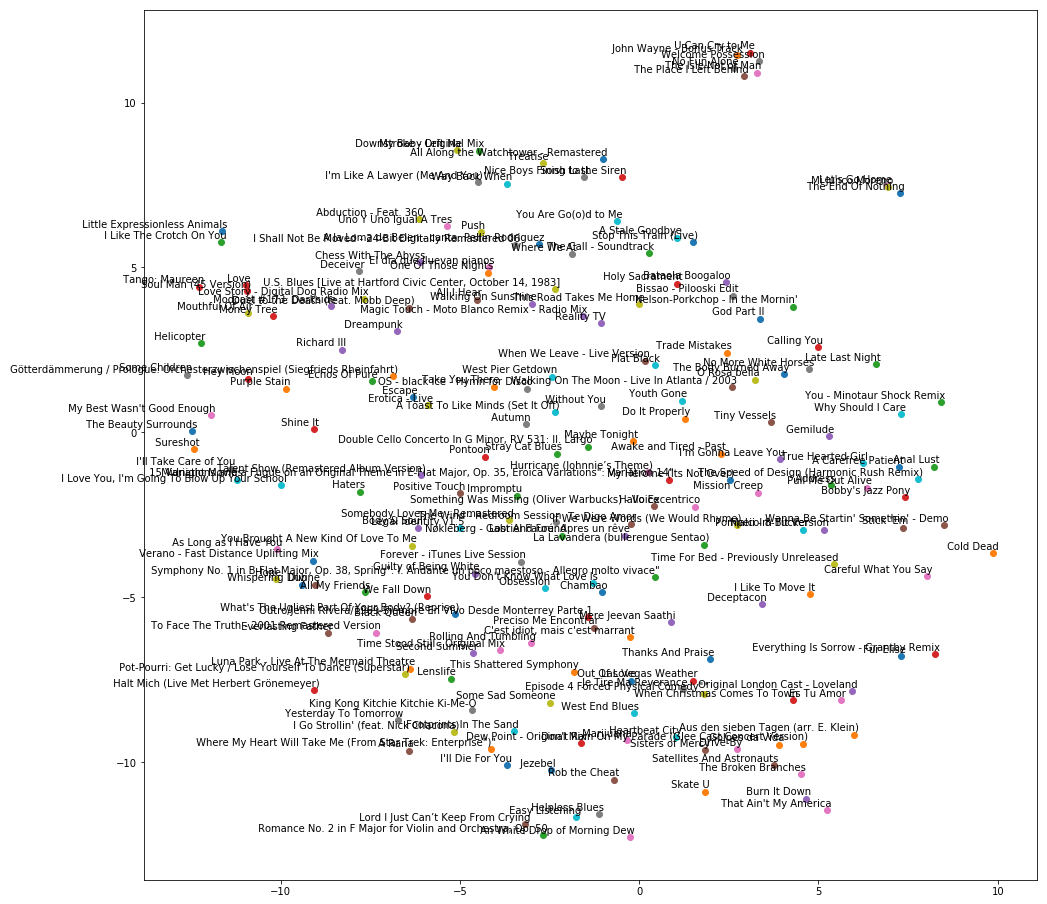

In [110]:
def label_format(label, condition=0):
    if condition == 1:
        return label.split("-", 1)[0]
    elif condition == 2:
        return label.split("-", 1)[1]
    else:
        return label


plt.figure(figsize=(16, 16)) 

for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i,0],X_tsne[i,1])
    plt.annotate(label_format(labels[i], 2),
                 xy=(X_tsne[i,0],X_tsne[i,1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In [65]:
X_tsne[1,:]

array([-4.7810283 , -0.61861974], dtype=float32)

In [64]:
X_tsne[1,0]

-4.7810283